In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list)
img_size = (224,224)

True


In [2]:
(train_data, test_data), ds_info = tfds.load(
    name= "food101",
    shuffle_files= True,
    split =["train", "validation"],
    download = True,
    data_dir = 'Data',
    as_supervised= True,
    with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to Data/food101/2.0.0.incompleteR27JH0/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to Data/food101/2.0.0.incompleteR27JH0/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to Data/food101/2.0.0. Subsequent calls will reuse this data.


In [3]:
class_names = ds_info.features['label'].names

In [4]:
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [5]:
for img, lab in train_one_sample:
  print(img)
  print(lab)

tf.Tensor(
[[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]

 [[ 77  80  89]
  [ 75  78  87]
  [ 82  86  95]
  ...
  [115 189 252]
  [117 192 255]
  [118 194 255]]

 ...

 [[159 166 194]
  [154 161 187]
  [171 178 204]
  ...
  [219 216 235]
  [223 220 239]
  [227 226 244]]

 [[170 179 208]
  [169 179 206]
  [173 183 210]
  ...
  [218 217 235]
  [223 222 240]
  [226 227 245]]

 [[168 177 206]
  [170 179 208]
  [152 162 189]
  ...
  [224 223 241]
  [228 229 247]
  [231 232 250]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(16, shape=(), dtype=int64)


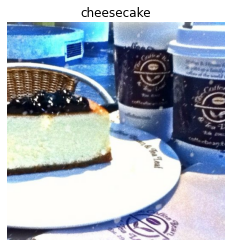

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.imshow(img.numpy())
plt.title(class_names[lab.numpy()])
plt.axis('off')
plt.show()

In [7]:
def preprocess_img(img, label):
  img = tf.image.resize(img, size = img_size)
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [8]:
test_data
#test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

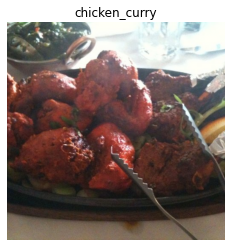

In [9]:
for img, lab in train_data.take(1):
  plt.imshow(img.numpy()/255.)
  plt.title(class_names[lab.numpy()])
  plt.axis('off')
  plt.show()

In [10]:
train_data = train_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [11]:
train_data

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [12]:
import datetime
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

log_dir = "Tensorboard/Full-Data-Fine-Tuning/EfficientNet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             #tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoint_EfficientNet_Full_Data_Fine_Tuning/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

mixed_precision.global_policy()

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


<Policy "mixed_float16">

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=img_size+(3,), name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)



16719872/16705208 [==============================] - 0s 0us/step


In [14]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model
loaded_gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

--2021-12-05 18:38:02--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  21.2MB/s    in 0.8s    

2021-12-05 18:38:04 (21.2 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: download

In [15]:
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 100s 104ms/step - loss: 1.0881 - accuracy: 0.7065


In [16]:
for layer in loaded_gs_model.layers:
  layer.trainable = True
  print(layer.trainable)

True
True
True
True
True


In [ ]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - 1196s 483ms/step - loss: 1.6392 - accuracy: 0.5814 - val_loss: 1.2293 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 1147s 476ms/step - loss: 1.1823 - accuracy: 0.6846 - val_loss: 0.9465 - val_accuracy: 0.7426 - lr: 0.0010
Epoch 3/100
1503/2368 [==================>...........] - ETA: 6:48 - loss: 1.0637 - accuracy: 0.7252

In [23]:
loaded_gs_model.load_weights('/content/model_ep_03_val_accuracy_0.7383.ckpt')

In [28]:
results = loaded_gs_model.evaluate(test_data)

results #[0.9820833206176758, 0.7346930503845215] 73% accuracy!!!

790/790 [==============================] - 76s 96ms/step - loss: 0.9821 - accuracy: 0.7347


[0.9820833206176758, 0.7346930503845215]